# Stimare Q function ottimale
## 1. Quanto tempo ci mette per convergere a Q*, al variare di tau
## 2. Distanza tra Q* e Q_t 
## 3. distanza tra Q_0 e Q_0 appresa tramite i valori di tau
## 4. cercare di integrare i bound trovati

### Estrarre policy da Q
### Confrontare due diverse Q valutando diverse metriche 
### Calcolare Q*
### Tentativo di implementazione di un curriculum
### Plot functions

In [1]:
import numpy as np
from TMDP import TMDP
from river_swim import River

from algorithms import *
import matplotlib as mpl
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
import math
from utils import *

In [2]:
# Test with tau=0.9
nS = 8
gamma = 0.9
river = River(nS, gamma, 5, 1000)
tau = 0.9
xi = np.ones(river.nS)*1/river.nS
tmdp = TMDP(river, xi, tau, gamma)

In [3]:
results = []

r_s_a = compute_r_s_a(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward)
Q_star = bellman_optimal_q(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward, 1e-4, gamma)
J = get_expected_avg_reward(tmdp.nS, tmdp.nA, tmdp.P_mat, get_policy(Q_star), tmdp.reward, tmdp.gamma, tmdp.mu)
delta_q = np.linalg.norm(Q_star - Q_star, np.inf)
print(delta_q)
results.append({"type":"Bellman", "Q": Q_star, "tau":"/", "J":J, "policy":get_policy(Q_star), "delta_q":delta_q})
print(results)

0.0
[{'type': 'Bellman', 'Q': array([[ 68.054,  70.06 ],
       [ 63.054,  96.009],
       [ 86.408, 140.217],
       [126.195, 206.885],
       [186.197, 305.732],
       [275.159, 451.916],
       [406.724, 668.02 ],
       [601.218, 987.469]]), 'tau': '/', 'J': 35.595799375000006, 'policy': array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]]), 'delta_q': 0.0}]


In [4]:

""" xi = np.ones(river.nS)*1/river.nS
gamma = 0.9
river = River(gamma)

for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    s = tmdp.reset()
    M = 10000
    Q = np.zeros((tmdp.nS, tmdp.nA))
    ret = 0
    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])
    Q = Q_learning(tmdp, s, a, Q, M)
    Qs.append({"tau":tau, "Q_function":Q, "env":tmdp})

for i in range(len(taus)):
    print("Tau:", Qs[i]['tau'])
    print(Qs[i]['Q_function']) """

' xi = np.ones(river.nS)*1/river.nS\ngamma = 0.9\nriver = River(gamma)\n\nfor tau in taus:\n    tmdp = TMDP(river, xi, tau, gamma)\n    s = tmdp.reset()\n    M = 10000\n    Q = np.zeros((tmdp.nS, tmdp.nA))\n    ret = 0\n    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])\n    Q = Q_learning(tmdp, s, a, Q, M)\n    Qs.append({"tau":tau, "Q_function":Q, "env":tmdp})\n\nfor i in range(len(taus)):\n    print("Tau:", Qs[i][\'tau\'])\n    print(Qs[i][\'Q_function\']) '

In [5]:
""" pi = get_policy(Qs[-2]['Q_function'])
pi_prime = get_policy(Qs[-1]['Q_function'])

print(pi)
print(pi_prime) """

" pi = get_policy(Qs[-2]['Q_function'])\npi_prime = get_policy(Qs[-1]['Q_function'])\n\nprint(pi)\nprint(pi_prime) "

In [6]:

taus = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
Q = np.zeros((tmdp.nS, tmdp.nA))
# Curriculul for decreasing values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    M = 20000
    s = tmdp.reset()
    ret = 0
    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])
    Q = Q_learning(tmdp, s, a, Q, M)
delta_q = np.linalg.norm(Q_star - Q, np.inf)
J = get_expected_avg_reward(tmdp.nS, tmdp.nA, tmdp.P_mat, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)
results.append({"type":"curriculum", "Q": Q, "tau":"1 -> 0", "J":J, "policy":get_policy(Q), "delta_q":delta_q})



In [7]:
# Learning from scratch with different values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    Q = np.zeros((tmdp.nS, tmdp.nA))
    M = 20000
    
    s = tmdp.reset()
    ret = 0
    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])
    Q = Q_learning(tmdp, s, a, Q, M)
    delta_q = np.linalg.norm(Q_star - Q, np.inf)
    J = get_expected_avg_reward(tmdp.nS, tmdp.nA, tmdp.P_mat_tau, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)
    results.append({"type":"scratch", "Q": Q, "tau":"{:.1f}".format(tau), "J":J, "policy":get_policy(Q),"delta_q":delta_q})

In [8]:
# Read previous results from file
try:
    res = read_results(tmdp.nS, tmdp.nA, "river_swim")
except:
    res = []
    
# Add current results to old ones
for r in results:
    res.append(r)





In [9]:
# Update overall results
write_results(tmdp.nS, tmdp.nA, "river_swim", res, 'w')
agg_res = aggregate_results(res, len(results))

In [10]:
print(agg_res)

[{'type': 'Bellman', 'Q': array([[ 68.054,  70.06 ],
       [ 63.054,  96.009],
       [ 86.408, 140.217],
       [126.195, 206.885],
       [186.197, 305.732],
       [275.159, 451.916],
       [406.724, 668.02 ],
       [601.218, 987.469]]), 'tau': '/', 'J': [365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843, 365.78861003317843

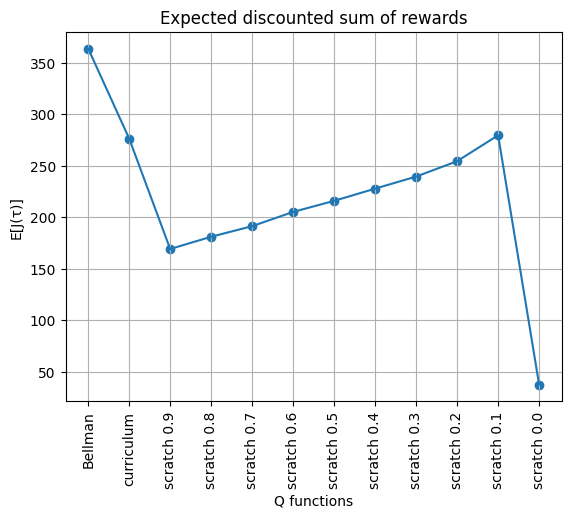

In [11]:
x = []
y = []
for res in agg_res:
    x.append(res['avg_J'])
    label = res['type'] + " " + str(res['tau']) if res['type'] == 'scratch' else res['type']
    y.append(label)

#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
plt.scatter(y, x)
plt.plot(y, x)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Expected discounted sum of rewards")
plt.grid(visible=True)




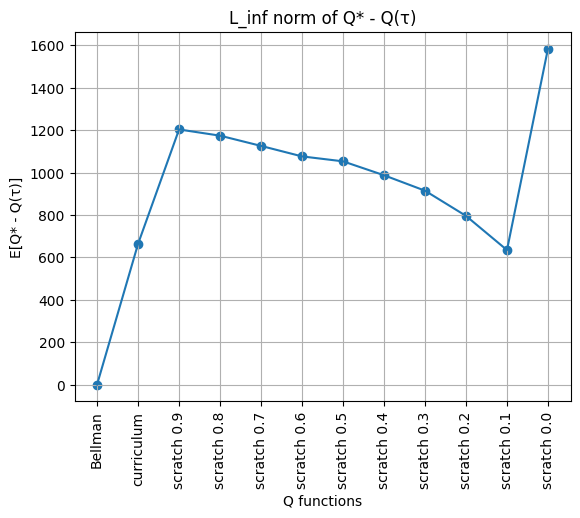

In [12]:
x = []
y = []
for res in agg_res:
    x.append(res['avg_delta_q'])
    label = res['type'] + " " + str(res['tau']) if res['type'] == 'scratch' else res['type']
    y.append(label)

#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
plt.scatter(y, x)
plt.plot(y, x)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel("E[Q* - Q(τ)]")
plt.title("L_inf norm of Q* - Q(τ)")
plt.grid(visible=True)

In [13]:
print(len(agg_res[0]['J']))

170


In [14]:
V_star = get_value_function(Q_star)
print(V_star)

[ 70.06   96.009 140.217 206.885 305.732 451.916 668.02  987.469]


In [15]:
def get_state_action_nextstate_value_function(nS, nA, r_s_a, gamma, V):
    U = np.zeros((nS, nA, nS))
    for s in range(nS):
        for a in range(nA):
            for s_prime in range(nS):
                U[s, a, s_prime] = r_s_a(s, a) + gamma*V[s_prime]
    return U